In [119]:
import pandas as pd
import os
import seaborn as sns
from riskyneuroarousal.utils.load_data import load_behavioral_data
import numpy as np
import matplotlib.pyplot as plt
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


For every subject, compute their dist_from_indiff


In [95]:
behavior = load_behavioral_data(min_RT = 0.2)
# prob_accept is 0 if response_int 1, 1/3 if response_int 2, 2/3 if response_int 3, 1 if response_int 4
behavior["prob_accept"] = behavior["response_int"].replace({1: 0, 2: 1/3, 3: 2/3, 4: 1})
sub_cond = behavior[["sub", "condition"]].drop_duplicates()

In [96]:
%%R -i behavior
library(lme4)
library(lmerTest)

In [97]:
%%R
# for each subject, run acccept ~ gain + loss
# and save the coefficients
gain <- c()
loss <- c()
subs <- c()
for (i in unique(behavior$sub)) {
    sub_behavior = behavior[behavior$sub == i,]
    model = glm(accept ~ gain + loss, data = sub_behavior, family=binomial)
    gain <- c(gain, unname(coef(model)["gain"]))
    loss <- c(loss, unname(coef(model)["loss"]))
    subs <- c(subs, i)
}

In addition: There were 14 warnings (use warnings() to see them)


In [102]:
%%R -o indiff
indiff <- data.frame(sub = subs, gain = gain, loss = loss)

In [103]:
indiff["slope"] = np.abs(indiff["loss"] / indiff["gain"])
indiff = indiff.merge(sub_cond, on = "sub")

<Axes: xlabel='slope', ylabel='Count'>

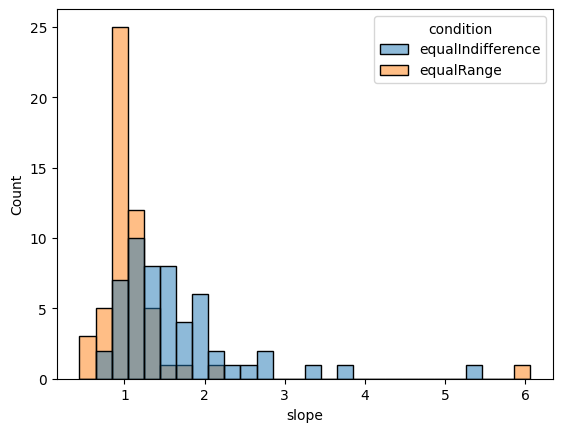

In [107]:
sns.histplot(x = "slope", hue = "condition", data = indiff)

In [117]:
behavior = behavior.merge(indiff[["sub", "slope"]], on = "sub")

In [140]:
behavior["dist_indiff"] = np.abs((behavior["gain"] - behavior["slope"] * behavior["loss"]) / np.sqrt(1 + behavior["slope"]**2))

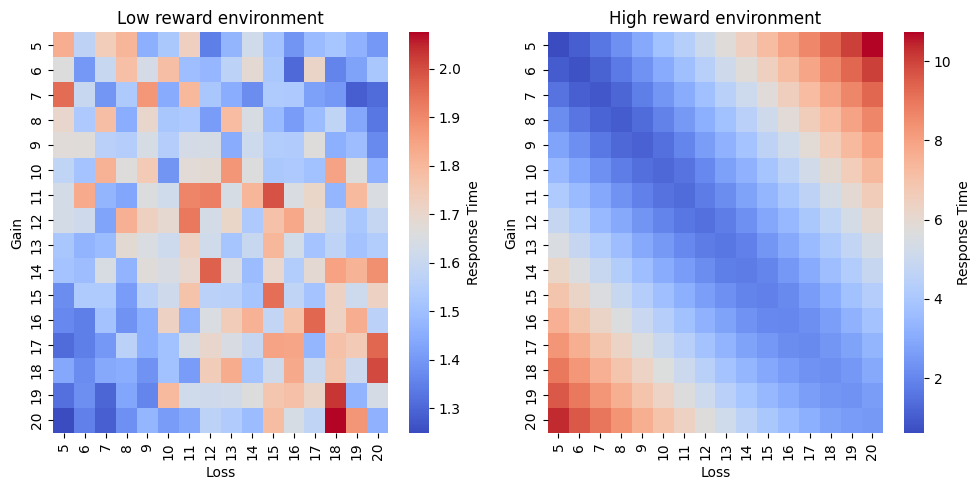

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = behavior.query("condition == 'equalRange'").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[0])
axs[0].set_title("Low reward environment")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = behavior.query("condition == 'equalRange'").groupby(['gain', 'loss'])['dist_indiff'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response Time'}, ax = axs[1])
axs[1].set_title("High reward environment")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

In [133]:
# Load all the data
dir = "/Users/gustxsr/Documents/Stanford/PoldrackLab/PAPERS/paper1_loss_aversion_pupil/eye_data/NARPS_MG_asc_processed"
pupil_data = []

for file in os.listdir(dir):
    if file.endswith("baseline.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        pupil_data.append(csv)

pupil_data = pd.concat(pupil_data)
pupil_data = pupil_data.rename(columns={"trial_num": "trial"})
pupil_data = pupil_data.merge(behavior, on=["sub", "trial", "run"])

In [156]:
%%R -i pupil_data -o pupil_data
model2 <- lmer(RT ~ gain*condition + loss*condition + dist_indiff*condition + (1|sub), data=pupil_data)
pupil_data["residuals"] = resid(model2)

In [193]:
# for each sub, divide baseline into 4 bins
# and assign the bin number to each trial]
num_quantiles = 5
pupil_data['qbaseline'] = pupil_data.groupby('sub')['baseline'].transform(lambda x: pd.qcut(x, num_quantiles, labels=False))

In [194]:
new = pupil_data.groupby(['sub', 'qbaseline', 'condition'])['residuals'].mean().reset_index()
new['residuals'] = -new['residuals']

<Axes: xlabel='qbaseline', ylabel='residuals'>

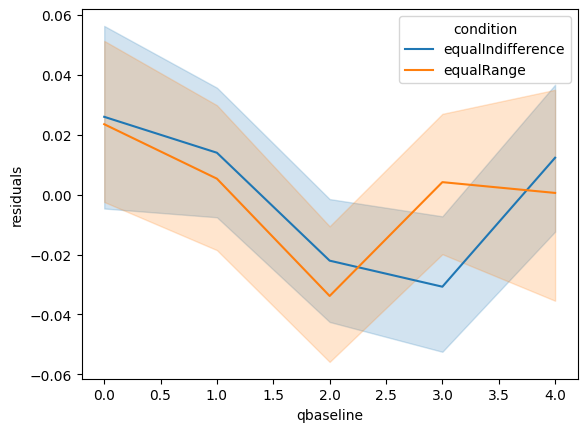

In [195]:
sns.lineplot(x = "qbaseline", y = "residuals", hue = "condition", data = new)

In [148]:
%%R -i pupil_data -o residuals3
# Is there an effect of accepting on response time between conditions? And if so, is this due to the gain and loss?
# Model 2: Predict Response Time as a function of condition, gain, loss, distance from indifference and response.
model3 <- lmer(RT ~ gain + loss + dist_indiff + (1|sub), data=pupil_data[pupil_data$condition == 'equalRange', ])
# residuals
residuals3 <- resid(model3)


In [150]:
%%R -i pupil_data -o residuals4
# Is there an effect of accepting on response time between conditions? And if so, is this due to the gain and loss?
# Model 2: Predict Response Time as a function of condition, gain, loss, distance from indifference and response.
model4 <- lmer(RT ~ gain + loss + dist_indiff + baseline + (1|sub), data=pupil_data[pupil_data$condition == 'equalIndifference', ])
# add a column for the residuals
pupil_data["residuals4"] = residuals4


In [154]:
residuals3

array([ 0.23441533, -0.77382509, -0.24970929, ..., -0.11540014,
       -0.47507455, -0.48901478], shape=(6868,))

In [153]:
pupil_data["residuals"] = np.nan

pupil_data[pupil_data["condition"] == "equalRange", "residuals"] = residuals3
pupil_data[pupil_data["condition"] == "equalIndifference", "residuals"] = residuals4

ValueError: Length of values (6868) does not match length of index (13988)